<a href="https://colab.research.google.com/github/tomonari-masada/course2023-sml/blob/main/09_logistic_regression_example.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 2023/06/10の課題
 * https://www.kaggle.com/uciml/pima-indians-diabetes-database

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import MinMaxScaler
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.metrics import roc_auc_score, auc, average_precision_score, roc_curve
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.metrics import PrecisionRecallDisplay

%config InlineBackend.figure_format = 'retina'

In [2]:
diabetes = pd.read_csv('/content/drive/MyDrive/data/diabetes.csv')

In [3]:
y = diabetes['Outcome']
X = diabetes.drop('Outcome', axis=1)

In [4]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15, random_state=123)

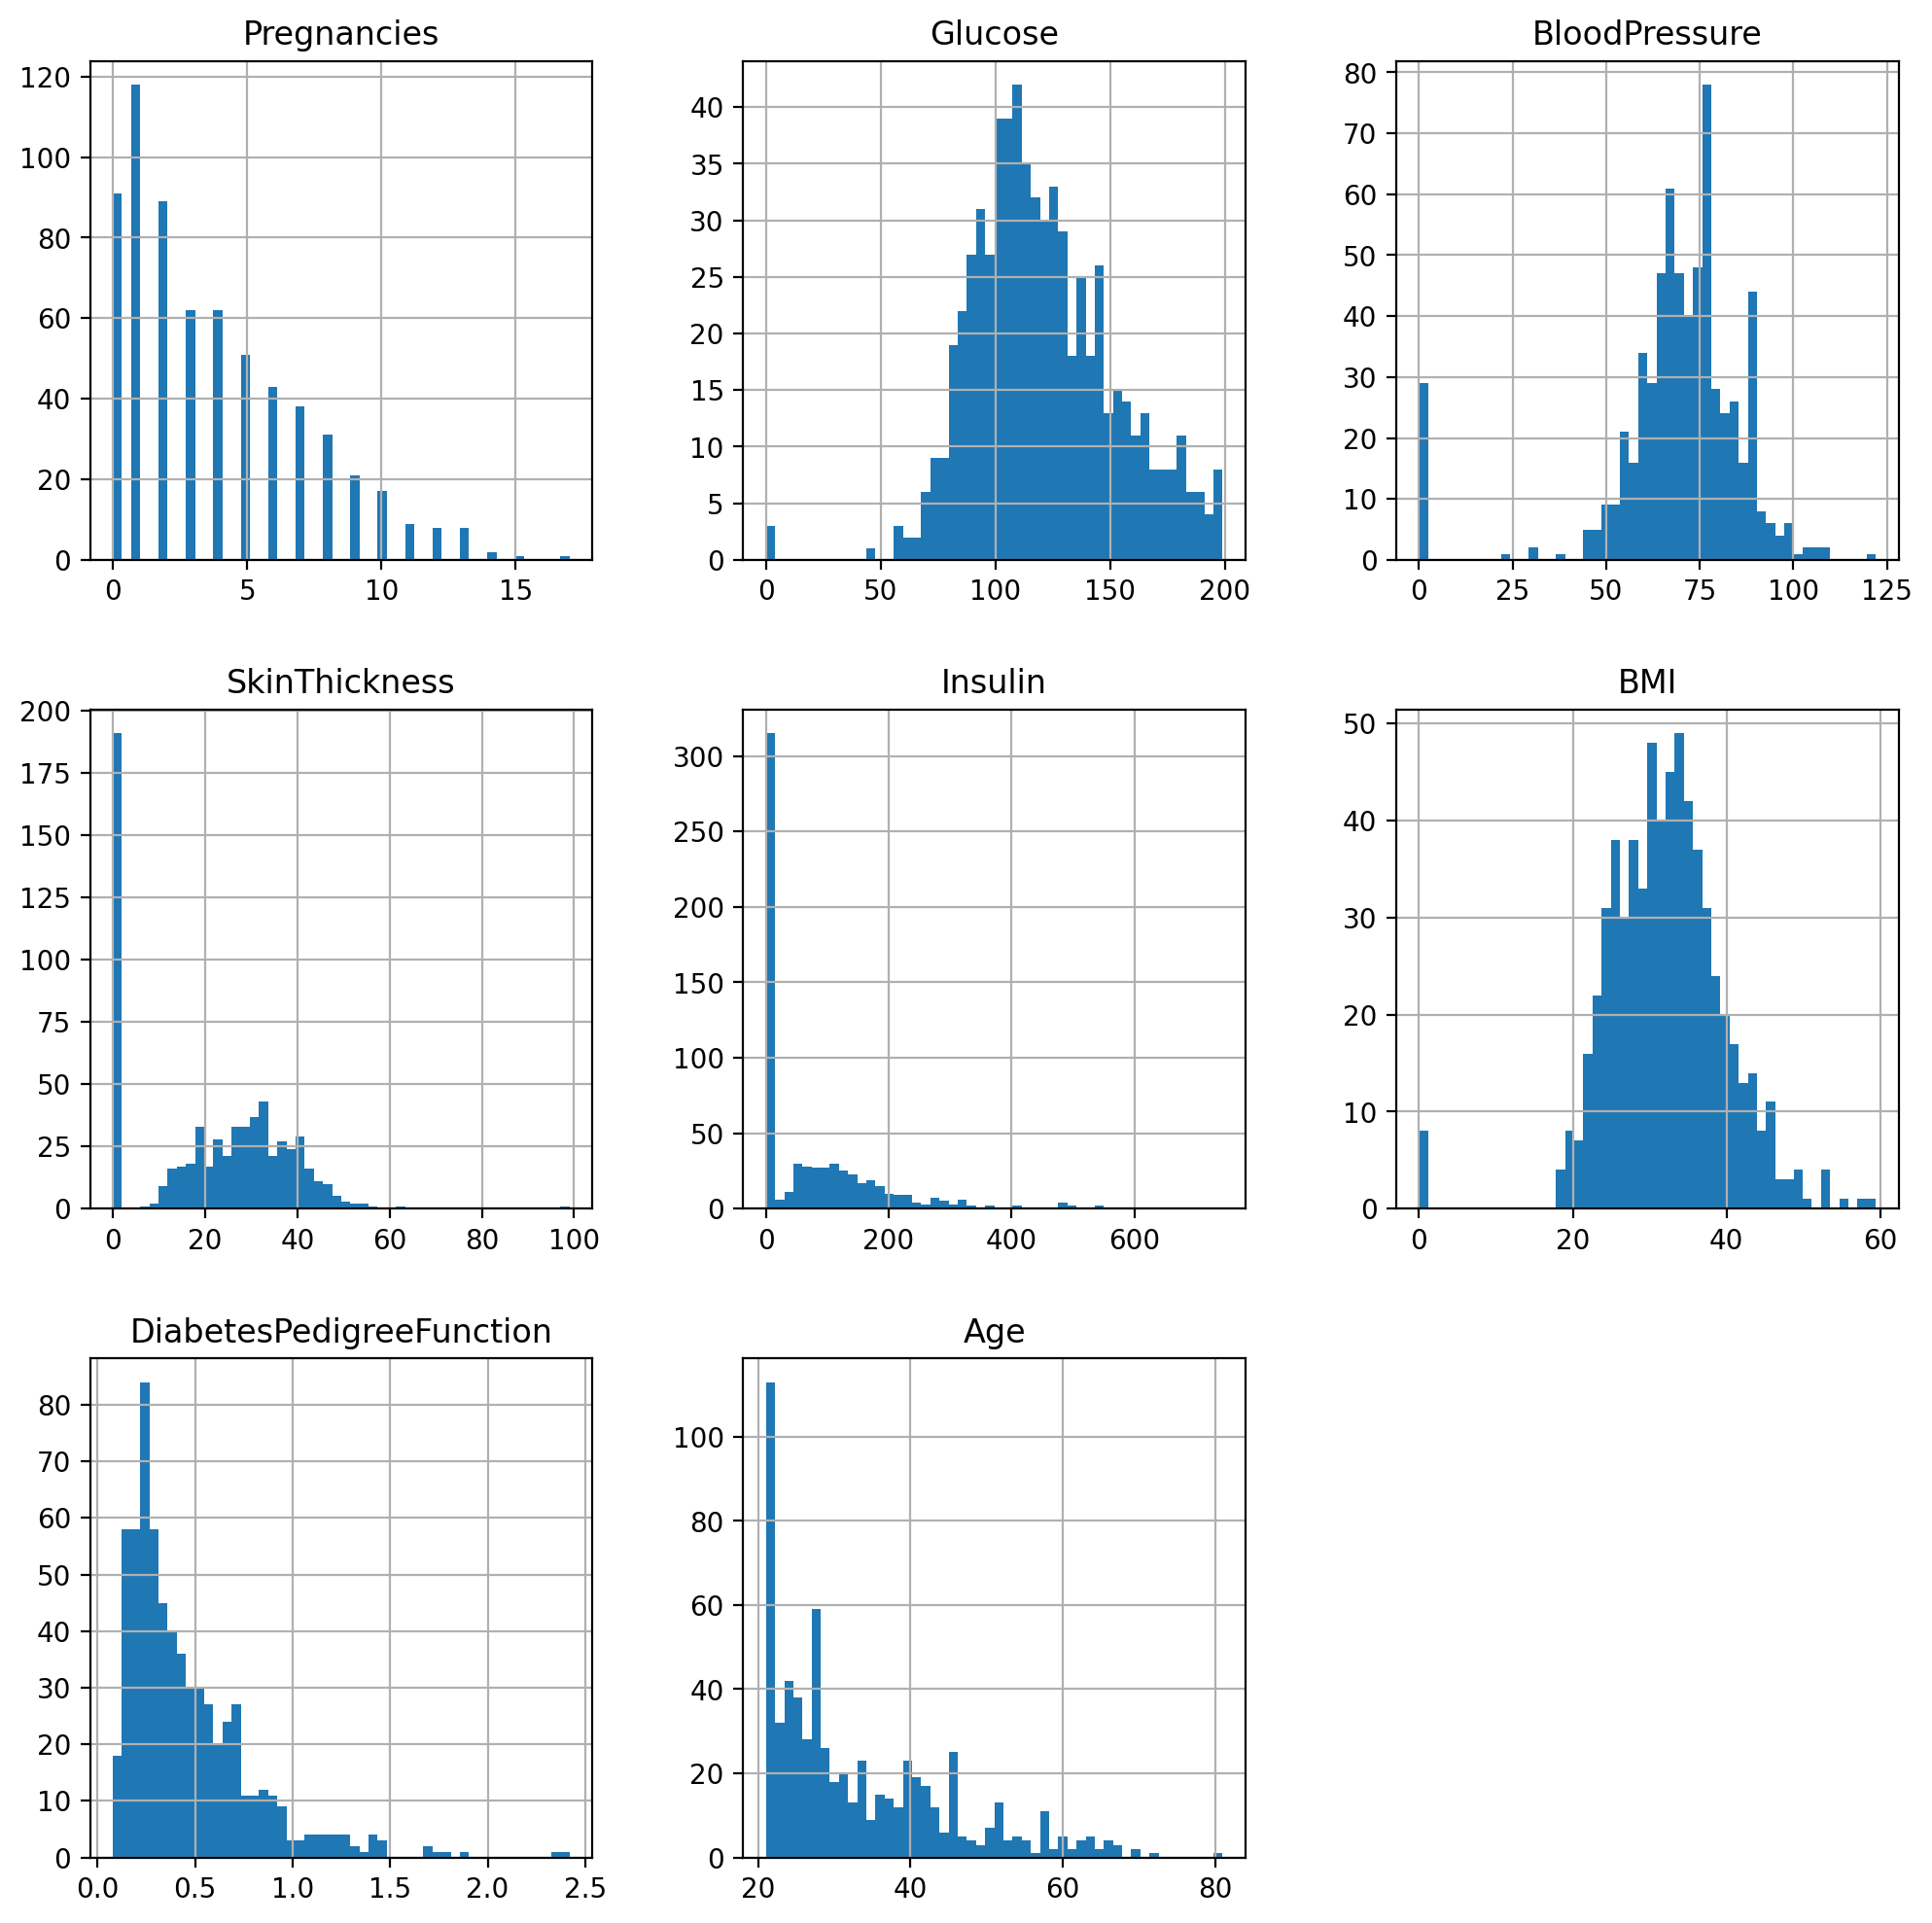

In [5]:
X_train.hist(bins=50, figsize=(12,12));

## ベースライン: チューニングなしのロジスティック回帰をテストデータで評価

In [6]:
baseline = LogisticRegression(max_iter=1000, random_state=123)
baseline.fit(X_train, y_train)
print(f'test score: {baseline.score(X_test, y_test):.4f}')
y_test_pred_proba = baseline.predict_proba(X_test)
print(f'ROC AUC: {roc_auc_score(y_test, y_test_pred_proba[:,1]):.4f}')
print(f'Average precision: {average_precision_score(y_test, y_test_pred_proba[:,1]):.4f}')

test score: 0.8103
ROC AUC: 0.8617
Average precision: 0.8186


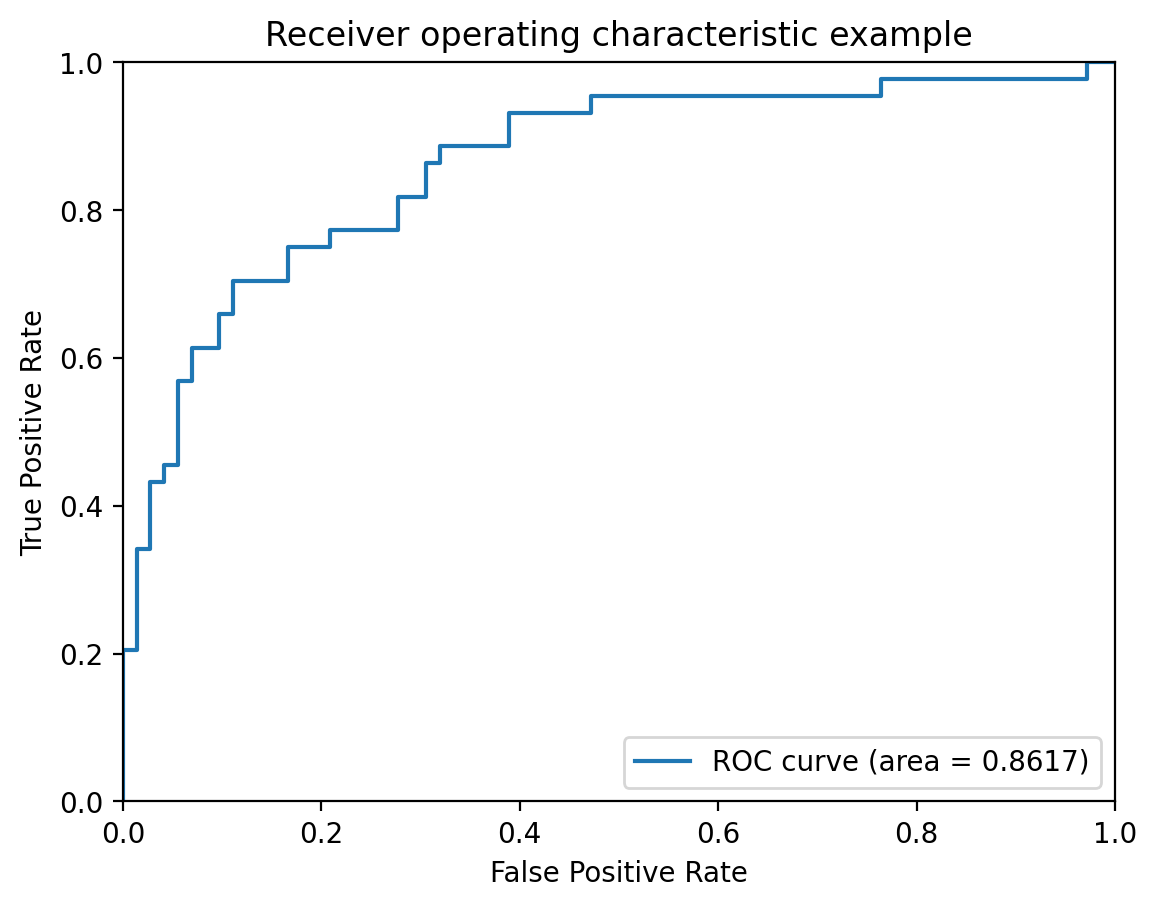

In [7]:
y_score = baseline.decision_function(X_test)

fpr, tpr, _ = roc_curve(y_test, y_score)
roc_auc = auc(fpr, tpr)

plt.plot(fpr, tpr, label=f'ROC curve (area = {roc_auc:.4f})')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right");

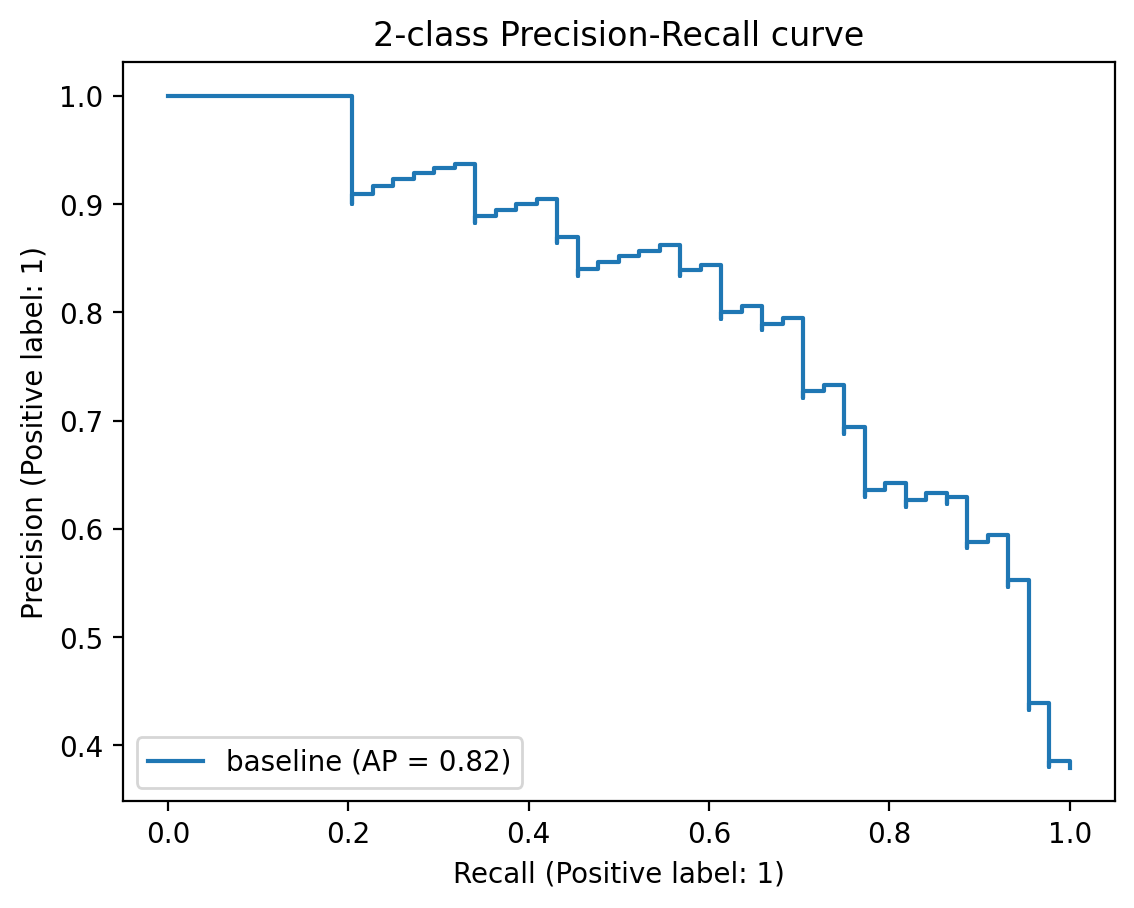

In [8]:
fig, ax = plt.subplots()
PrecisionRecallDisplay.from_estimator(baseline, X_test, y_test, name="baseline", ax=ax)
ax.set_title("2-class Precision-Recall curve");

* これをベースラインとみなす。
* これより良い結果を得るべく、試行錯誤する。
* 試行錯誤した結果として辿り着いたモデルで、最後に一回、テストデータ上での評価を行う。

## グリッドサーチ＆交差検証

* Pregnanciesについては0は意味のある値なのでimputationは行わない。

In [9]:
preprocessor = ColumnTransformer(transformers=[
    ("imputer", SimpleImputer(), ['BloodPressure', 'BMI', 'Glucose', 'SkinThickness', 'Insulin']),
])

In [10]:
pipeline = Pipeline(steps=[
    ("preprocessor", preprocessor),
     ("scaler", MinMaxScaler()),
      ("lr", LogisticRegression(max_iter=1000)),
])

In [11]:
param_grid = {
    "preprocessor__imputer__strategy": ["median", "mean", "constant"],
    "lr__C": 10.0 ** np.arange(-1, 4),
    "lr__penalty": [None, "l1", "l2"],
    }

In [12]:
rskf = RepeatedStratifiedKFold(n_splits=10, n_repeats=4, random_state=12345)
clf = GridSearchCV(pipeline, param_grid, cv=rskf, n_jobs=-1, scoring="average_precision")

In [13]:
clf.fit(X_train, y_train)

/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:378: FitFailedWarning: 
600 fits failed out of a total of 1800.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
600 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/pipeline.py", line 405, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py", line 1162, in fit
    solver = _check_solver(self.solver, self.penalty, self.dua

GridSearchCV(cv=RepeatedStratifiedKFold(n_repeats=4, n_splits=10, random_state=12345),
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(transformers=[('imputer',
                                                                         SimpleImputer(),
                                                                         ['BloodPressure',
                                                                          'BMI',
                                                                          'Glucose',
                                                                          'SkinThickness',
                                                                          'Insulin'])])),
                                       ('scaler', MinMaxScaler()),
                                       ('lr',
                                        LogisticRegression(max_iter=1000))]),
             n_jobs=-1,
             param_grid={'lr__C': array([1.e-01, 1.e+00, 1.e+01, 1.e+02, 1.e+03]),
                         'lr__penalty': [None, 'l1', 'l2'],
                         'preprocessor__imputer__strategy': ['median', 'mean',
                                                             'constant']},
             scoring='average_precision')

In [14]:
results = pd.DataFrame.from_dict(clf.cv_results_).sort_values(by=["rank_test_score"])
results

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_lr__C,param_lr__penalty,param_preprocessor__imputer__strategy,params,split0_test_score,split1_test_score,...,split33_test_score,split34_test_score,split35_test_score,split36_test_score,split37_test_score,split38_test_score,split39_test_score,mean_test_score,std_test_score,rank_test_score
24,0.026548,0.011868,0.010052,0.004706,10.0,l2,median,"{'lr__C': 10.0, 'lr__penalty': 'l2', 'preproce...",0.800876,0.834982,...,0.736941,0.741873,0.706283,0.745972,0.711955,0.694246,0.768934,0.702848,0.070837,1
25,0.023278,0.013793,0.008629,0.005949,10.0,l2,mean,"{'lr__C': 10.0, 'lr__penalty': 'l2', 'preproce...",0.800876,0.834982,...,0.736941,0.741873,0.706283,0.745972,0.711955,0.694246,0.768934,0.702848,0.070837,1
26,0.023231,0.010548,0.008595,0.004179,10.0,l2,constant,"{'lr__C': 10.0, 'lr__penalty': 'l2', 'preproce...",0.800876,0.834982,...,0.736941,0.741873,0.706283,0.745972,0.711955,0.694246,0.768934,0.702848,0.070837,1
19,0.026376,0.013351,0.009982,0.006648,10.0,None,mean,"{'lr__C': 10.0, 'lr__penalty': None, 'preproce...",0.799432,0.832113,...,0.732569,0.742655,0.706283,0.744336,0.713560,0.694221,0.759614,0.702818,0.071374,4
18,0.043570,0.018092,0.015502,0.009308,10.0,None,median,"{'lr__C': 10.0, 'lr__penalty': None, 'preproce...",0.799432,0.832113,...,0.732569,0.742655,0.706283,0.744336,0.713560,0.694221,0.759614,0.702818,0.071374,4
27,0.027988,0.005040,0.011288,0.004027,100.0,None,median,"{'lr__C': 100.0, 'lr__penalty': None, 'preproc...",0.799432,0.832113,...,0.732569,0.742655,0.706283,0.744336,0.713560,0.694221,0.759614,0.702818,0.071374,4
28,0.025115,0.011721,0.011894,0.008783,100.0,None,mean,"{'lr__C': 100.0, 'lr__penalty': None, 'preproc...",0.799432,0.832113,...,0.732569,0.742655,0.706283,0.744336,0.713560,0.694221,0.759614,0.702818,0.071374,4
29,0.022857,0.006914,0.009595,0.004865,100.0,None,constant,"{'lr__C': 100.0, 'lr__penalty': None, 'preproc...",0.799432,0.832113,...,0.732569,0.742655,0.706283,0.744336,0.713560,0.694221,0.759614,0.702818,0.071374,4
11,0.020978,0.008671,0.009344,0.004432,1.0,None,constant,"{'lr__C': 1.0, 'lr__penalty': None, 'preproces...",0.799432,0.832113,...,0.732569,0.742655,0.706283,0.744336,0.713560,0.694221,0.759614,0.702818,0.071374,4
20,0.025747,0.009712,0.009419,0.004472,10.0,None,constant,"{'lr__C': 10.0, 'lr__penalty': None, 'preproce...",0.799432,0.832113,...,0.732569,0.742655,0.706283,0.744336,0.713560,0.694221,0.759614,0.702818,0.071374,4


## テストデータで最終評価

In [15]:
best_pipeline = clf.best_estimator_

In [16]:
best_pipeline.fit(X_train, y_train)
print(f'test score: {best_pipeline.score(X_test, y_test):.4f}')
y_test_pred_proba = best_pipeline.predict_proba(X_test)
print(f'ROC AUC: {roc_auc_score(y_test, y_test_pred_proba[:,1]):.4f}')
print(f'Average precision: {average_precision_score(y_test, y_test_pred_proba[:,1]):.4f}')

test score: 0.7845
ROC AUC: 0.8355
Average precision: 0.7927


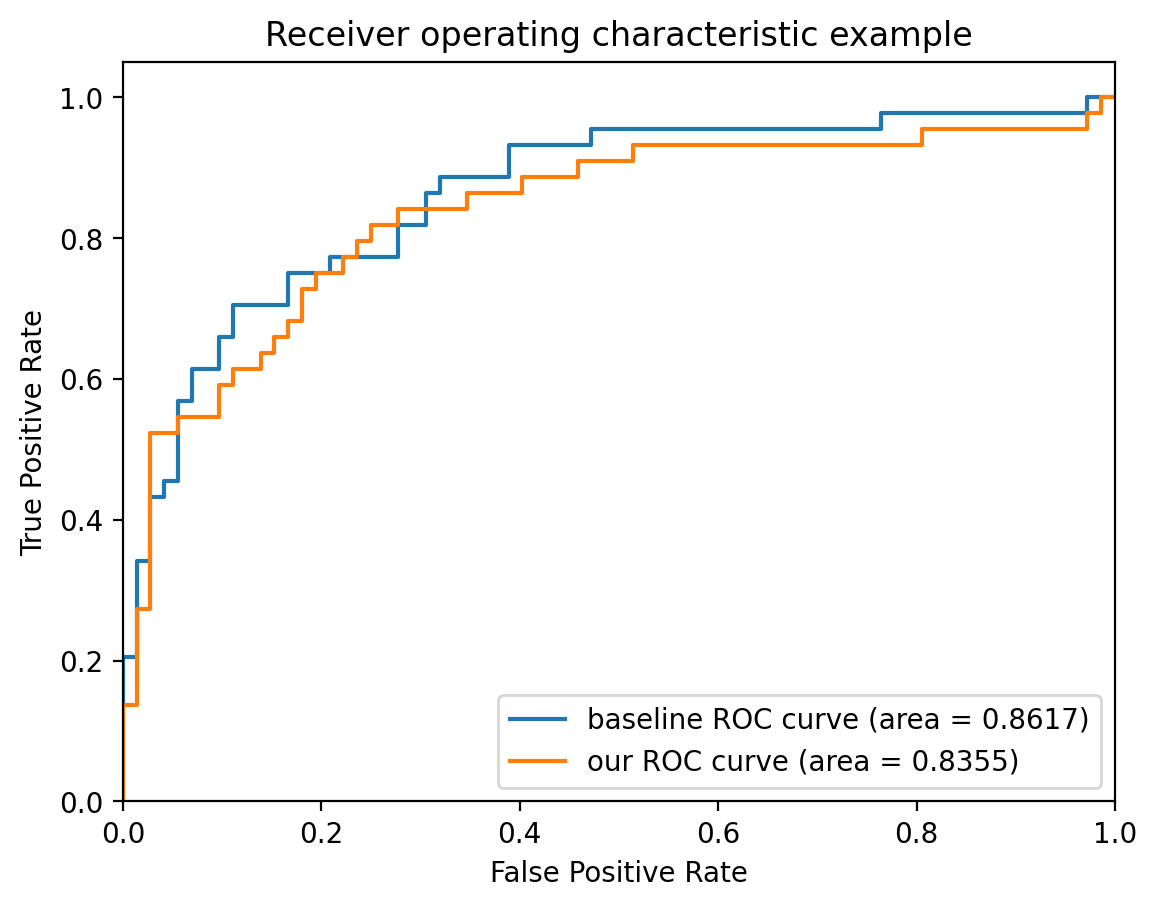

In [17]:
y_score = baseline.decision_function(X_test) # ベースラインには元のテストデータを使う
fpr, tpr, _ = roc_curve(y_test, y_score)
roc_auc = auc(fpr, tpr)

y_score_ours = best_pipeline.decision_function(X_test)
fpr_ours, tpr_ours, _ = roc_curve(y_test, y_score_ours)
roc_auc_ours = auc(fpr_ours, tpr_ours)

plt.plot(fpr, tpr, label=f'baseline ROC curve (area = {roc_auc:.4f})')
plt.plot(fpr_ours, tpr_ours, label=f'our ROC curve (area = {roc_auc_ours:.4f})')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right");

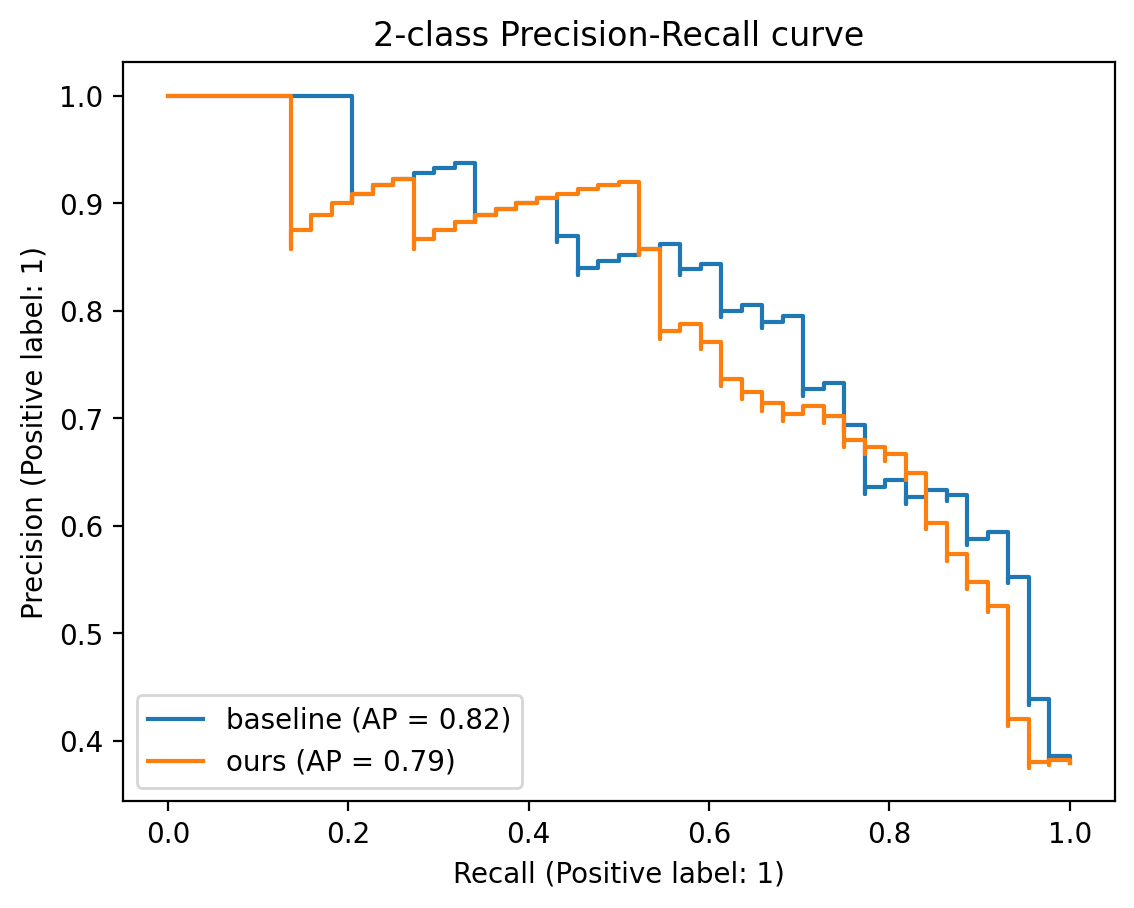

In [18]:
fig, ax = plt.subplots()
PrecisionRecallDisplay.from_estimator(baseline, X_test, y_test, name="baseline", ax=ax)
PrecisionRecallDisplay.from_estimator(best_pipeline, X_test, y_test, name="ours", ax=ax)
ax.set_title("2-class Precision-Recall curve");

* baselineよりも、positiveなインスタンスを見つけるのが、遅い。
 * 病気のように、positiveなインスタンスを早く見つけるのが望ましい場合、これは良くない。
* というか、どの評価指標でも、そもそもbaselineより良くなっていない・・・。